# MakeMore Tutorial

This is extension from the first notebook (just to have a clean start).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**HParams**

Hyper parameters used, so that we define them all in one place


In [10]:
heads = 5
emb_size = 64
hidden_layer = 512

**Data Loading**

Loads the names data and splits it into heads


In [4]:
import random
from typing import List, Callable
from torch import nn
from torch.nn import functional as F

# load the name data
with open("data/names.txt") as f:
    names = f.read().splitlines()

# print stats
print("Number of names: ", len(names))

# split names into bigrams
bigrams = {}
for name in names:
    ls = ["<T>"] + list(name.lower()) + ["<T>"]
    tpl = list(zip(ls, ls[1:]))
    for bigram in tpl:
        bigrams[bigram] = bigrams.get(bigram, 0) + 1
items = sorted(list(set([b for a, b in bigrams.keys()])))
pos_map = {v: k for k, v in enumerate(items)}
num_items = len(items)
t_bigrams = torch.zeros((num_items, num_items))


# split names into 3 datasets (based on percentages)
train_perc, dev_perc, eval_perc = 0.8, 0.1, 0.1

# shuffle and split names
random.shuffle(names)
train_names = names[: int(len(names) * train_perc)]
dev_names = names[
    int(len(names) * train_perc) : int(len(names) * (train_perc + dev_perc))
]
eval_names = names[int(len(names) * (train_perc + dev_perc)) :]

# print stats
print(f"Train: {len(train_names)}")
print(f"Dev: {len(dev_names)}")
print(f"Eval: {len(eval_names)}")


def gen_dataset(items: List[str], encode: Callable[[str], List[int]], heads: int):
    train = []
    label = []
    for name in items:
        ls = [0] * heads + encode(name) + [0]
        tpl = list(zip(ls, *[ls[i + 1 :] for i in range(heads)]))
        for bigram in tpl:
            train.append(bigram[:-1])
            label.append(bigram[-1])

    # convert to tensors and expand as one-hots
    train = torch.tensor(train)
    label = F.one_hot(torch.tensor(label), num_items)
    return train, label


def char_encoding(name: str) -> List[int]:
    return [pos_map[i] for i in list(name.lower())]


print(f"Vocab Size: {num_items}")

Number of names:  32033
Train: 25626
Dev: 3203
Eval: 3204
Vocab Size: 27


In [3]:
num_mlp_items = len(pos_map)

train_X, train_y = gen_dataset(train_names, char_encoding, heads=heads)
dev_X, dev_y = gen_dataset(dev_names, char_encoding, heads=heads)
eval_X, eval_y = gen_dataset(eval_names, char_encoding, heads=heads)
print(train_X.shape)
print(dev_X.shape)
print(eval_X.shape)

torch.Size([182516, 5])
torch.Size([22771, 5])
torch.Size([22859, 5])


**Helpers**

Some general helper functions


In [66]:
from torchviz import make_dot
from typing import Tuple, Any

# plots the given model
def plot_mlp(model, X=train_X):
    return make_dot(model.forward(X), params=dict(model.named_parameters()))


def compute_nll(model, X, y):
    # compute the loss
    probs = model.predict_proba(X)
    lhood = (probs * y).sum(dim=1)
    # take mean to make usre large data is still handlable
    return -torch.log(lhood).mean()


def count_parameters(model):
    # sum number of elements in all model parameters that take a gradient
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def grid_space_lr(exp_start, exp_end, num) -> Tuple[torch.Tensor, torch.Tensor]:
    # NOTE: this can be used by single training steps (random data) then check when the loss explodes
    # generate a grid of learning rates
    space = torch.linspace(exp_start, exp_end, num)
    return 10**space, space


def grid_search_lr(
    model,
    exp_start: int,
    exp_end: int,
    steps: int,
    train_X: torch.Tensor,
    train_y: torch.Tensor,
    loss_fct: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    batch_size: int = 1000,
):
    # generate grid space
    lrs, lri = grid_space_lr(exp_start, exp_end, steps)

    # train model for each learning rate
    losses = []
    for i in range(len(lrs)):
        # sample from trainX and trainY
        idx = torch.randint(0, train_X.shape[0], (batch_size,))
        batch_X = train_X[idx]
        batch_y = train_y[idx]

        # compute loss
        probs = model(batch_X)[0]
        loss = loss_fct(probs, batch_y)
        loss.backward()

        # optimize
        for p in model.parameters():
            p.data -= lrs[i] * p.grad.data
            p.grad.data.zero_()

        # compute loss
        losses.append(loss.sum().item())

    # plot data
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(lri, losses)
    ax.set_xlabel("Learning Rate Exp")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Learning Rate Exp")
    plt.show()

    return losses, lri

**MLP**

Definition of the MLP Model and define the learning rate curve.


Model has 179931 parameters


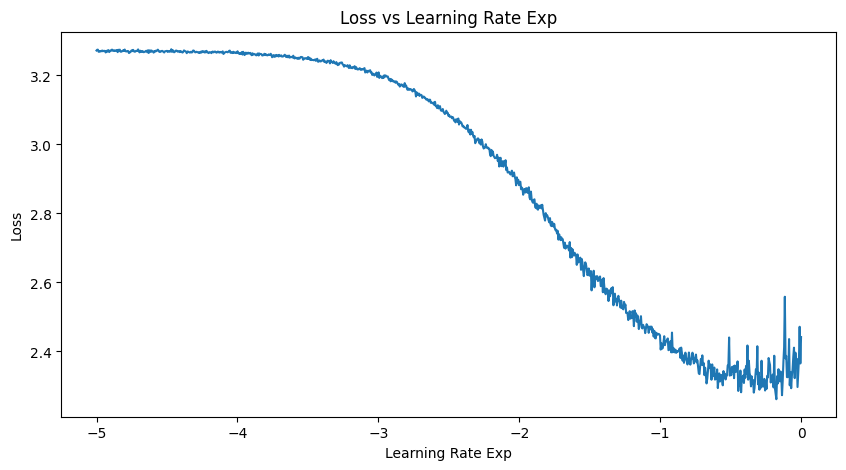

In [93]:
from sklearn.decomposition import PCA
from typing import Dict


class MLPNet(nn.Module):
    def __init__(
        self,
        char_map: Dict[int, str],
        num_items: int,
        emb_size: int = 64,
        hidden_size: int = 512,
        heads: int = 3,
        act: Callable[[torch.Tensor], torch.Tensor] = torch.tanh,
        residuals: bool = False,
    ):
        super(MLPNet, self).__init__()
        self.heads = heads
        self.emb_size = emb_size
        self.act = act
        self.char_map = char_map
        self.use_res = residuals

        # generate data
        self.emb_mat = nn.Parameter(
            torch.randn(num_items, emb_size, requires_grad=True)
        )
        self.hidden = nn.Linear(heads * emb_size, hidden_size)
        in_size = hidden_size + (emb_size * heads) if residuals else hidden_size
        self.out = nn.Linear(in_size, num_items)

    def forward(self, x):
        # update the X (if out of shape)
        x = x.unqueeze(0) if len(x.shape) == 1 else x
        x = x.long()

        # retrieve embeddings and concat
        embs = self.emb_mat[x]
        embs = embs.view(-1, self.heads * self.emb_size)
        embs = self.act(embs)

        hidden = self.act(self.hidden(embs))

        # add residual
        if self.use_res:
            hidden = torch.cat((hidden, embs), dim=1)
        logits = self.out(hidden)
        return logits, hidden

    def predict_proba(self, x):
        return torch.softmax(self.forward(x)[0], dim=1)

    def predict(self, x):
        logits = self.predict_proba(x)
        return torch.argmax(logits, dim=1)

    def sample_word(self, size: int = 100) -> str:
        word = ""
        chars = [0] * self.heads
        for i in range(size):
            probs = self.predict_proba(torch.tensor([chars]))
            # sample from the distribution
            sample = torch.multinomial(probs[0], 1, replacement=True).item()
            if sample == 0:
                break

            chars = chars[1:] + [sample]
            word += self.char_map[sample]

        return word

    def plot_embeddings(self):
        emb_points = self.emb_mat.detach().numpy()

        # use PCA to reduce the dimensionality
        if emb_points.shape[1] > 2:
            pca = PCA(n_components=2)
            emb_points = pca.fit_transform(emb_points)

        # plot the embedding points on a 2D plane
        plt.figure(figsize=(10, 10))
        # and label the points
        plt.scatter(emb_points[:, 0], emb_points[:, 1], s=250)

        # plot the labels
        for i, label in enumerate(pos_map):
            plt.annotate(
                label,
                (emb_points[i, 0], emb_points[i, 1]),
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )
        plt.show()


# create model
def create_model(res = False):
    return MLPNet(
        items,
        num_items,
        emb_size=emb_size,
        hidden_size=hidden_layer,
        heads=heads,
        act=torch.nn.Tanh(),
        residuals=res
    )


model = create_model()
print(f"Model has {count_parameters(model)} parameters")
# plot the learning rate data
ce_loss = lambda p, y: F.cross_entropy(p, torch.argmax(y, dim=1))
losses, lri = grid_search_lr(
    create_model(), -5, 0, 1000, train_X, train_y, ce_loss, batch_size=5000
)

Epoch 0 - Train Loss: 2.3950366973876953 - Test Loss: 2.3965137004852295
Epoch 1 - Train Loss: 2.3496663570404053 - Test Loss: 2.3511736392974854
Epoch 2 - Train Loss: 2.3232903480529785 - Test Loss: 2.324521780014038
Epoch 3 - Train Loss: 2.300776481628418 - Test Loss: 2.3027734756469727
Epoch 4 - Train Loss: 2.2856009006500244 - Test Loss: 2.2879161834716797
Epoch 5 - Train Loss: 2.2734193801879883 - Test Loss: 2.2758634090423584
Epoch 6 - Train Loss: 2.26505970954895 - Test Loss: 2.2674379348754883
Epoch 7 - Train Loss: 2.2565512657165527 - Test Loss: 2.2596375942230225
Epoch 8 - Train Loss: 2.249403953552246 - Test Loss: 2.253232955932617
Epoch 9 - Train Loss: 2.2466533184051514 - Test Loss: 2.250519275665283
Epoch 10 - Train Loss: 2.2397804260253906 - Test Loss: 2.2441797256469727
Epoch 11 - Train Loss: 2.2617218494415283 - Test Loss: 2.2681212425231934
Epoch 12 - Train Loss: 2.2301886081695557 - Test Loss: 2.235137939453125
Epoch 13 - Train Loss: 2.224001884460449 - Test Loss: 2.

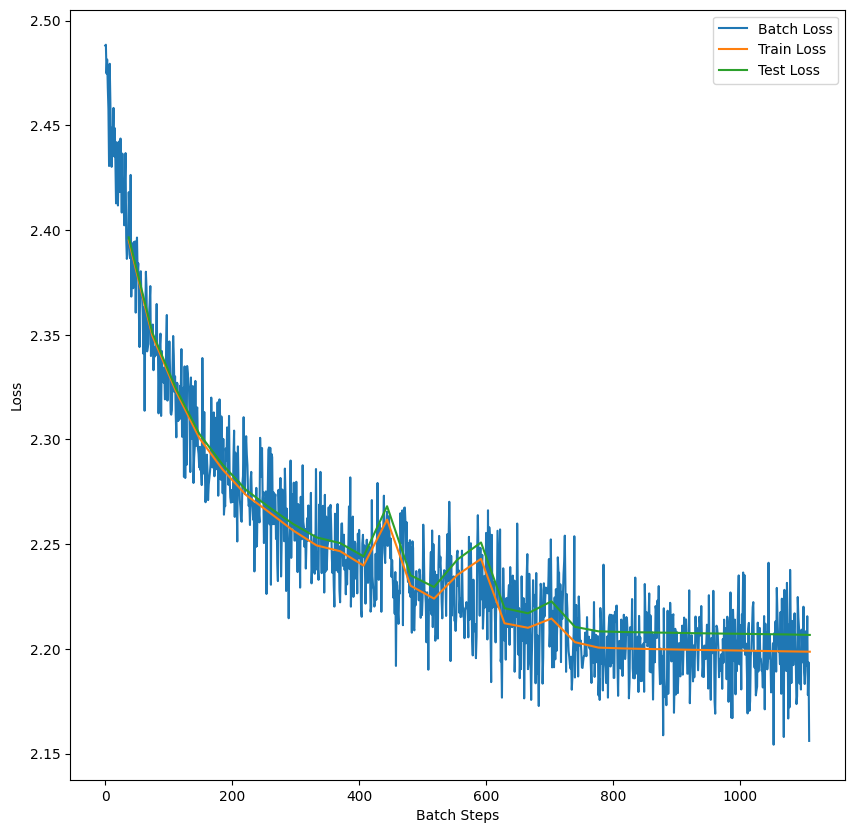

In [70]:
def clean_stats():
    return {
        "batch_loss": [],
        "train_loss": [],
        "test_loss": [],
        "epoch_steps": [],
    }


# define model and optimization cycle
def optimize(
    model: nn.Module,
    epochs: int,
    train_X: torch.Tensor,
    train_y: torch.Tensor,
    test_X,
    test_y,
    loss_fct,
    batch_size: int = 1000,
    lr: float = 1e-3,
    stats=None,
):
    # create some statistics
    stats = stats or clean_stats()

    # sample from trainX and trainY
    for ep in range(epochs):
        # shuffle the train data
        idx = torch.randperm(train_X.shape[0])
        train_X = train_X[idx]
        train_y = train_y[idx]

        # iterate over the batches
        for i in range(0, train_X.shape[0], batch_size):
            batch_X = train_X[i : i + batch_size]
            batch_y = train_y[i : i + batch_size]

            # compute loss
            probs = model(batch_X)[0]
            loss = loss_fct(probs, batch_y)
            loss.backward()

            # optimize
            for p in model.parameters():
                p.data -= lr * p.grad.data
                p.grad.data.zero_()

            # update statistics
            stats["batch_loss"].append(loss.sum().item())

        # compute epoch loss
        with torch.no_grad():
            train_loss = loss_fct(model(train_X)[0], train_y).sum().item()
            test_loss = loss_fct(model(test_X)[0], test_y).sum().item()
            stats["train_loss"].append(train_loss)
            stats["test_loss"].append(test_loss)
            stats["epoch_steps"].append(len(stats["batch_loss"]))

        print(f"Epoch {ep} - Train Loss: {train_loss} - Test Loss: {test_loss}")

    return stats


def plot_stats(stats: dict):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.plot(
        np.arange(len(stats["batch_loss"])), stats["batch_loss"], label="Batch Loss"
    )
    ax.plot(stats["epoch_steps"], stats["train_loss"], label="Train Loss")
    ax.plot(stats["epoch_steps"], stats["test_loss"], label="Test Loss")
    ax.set_xlabel("Batch Steps")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.show()


stats = optimize(
    model, 20, train_X, train_y, dev_X, dev_y, ce_loss, batch_size=5000, lr=2e-1
)
stats = optimize(
    model,
    10,
    train_X,
    train_y,
    dev_X,
    dev_y,
    ce_loss,
    batch_size=5000,
    lr=1e-2,
    stats=stats,
)
plot_stats(stats)

In [71]:
# predict
for i in range(10):
    print(f"Sample: {model.sample_word()}")

Sample: zaviann
Sample: avidan
Sample: kalai
Sample: jigra
Sample: amikanarra
Sample: selle
Sample: manyn
Sample: aroo
Sample: kaynah
Sample: ramaugra


## Introspection

**Initialization**

Adding additional function to better understanding the parts of the network.

There are a bunch of relevant parameters when it comes to initialization:

- fan_in = number of input units (that go into each neuron) - so for FC it is size of previous layer, for conv it is number of channels and kernel size
- non-linearities = based on the non-linearities we have different gains (e.g. tanh is 5/3, relu is sqrt(2)) - basically outlines how much value this passes on to the next layer

Finally there are different initialization methods that (to make sure distributions across items stay constant)

In [88]:
# init the weights and verify how
def init_weights(model: nn.Module, init_func):
    for p in model.parameters():
        init_func(p)


def uniform_init(p: nn.Parameter):
    torch.nn.init.uniform_(p.data, -1, 1)


def fixed_init(p: nn.Parameter):
    p.data.fill_(0.01)

def he_init(p: nn.Parameter):
    # NOTE: to compute this dynamically we would need have access to the lower layers
    if p.dim() > 1:
        torch.nn.init.kaiming_uniform_(p.data, a=0, mode="fan_in", nonlinearity="tanh")
    else:
        torch.nn.init.uniform_(p.data, -1, 1)

def weight_stats(model: nn.Module):
    for p in model.parameters():
        print(f"Weight Mean: {p.data.mean()} - Weight Std: {p.data.std()}")


uni_model = create_model()
print("Random")
weight_stats(uni_model)
print("Uniform")
init_weights(uni_model, uniform_init)
weight_stats(uni_model)

Random
Weight Mean: 0.020622363314032555 - Weight Std: 1.0027610063552856
Weight Mean: 8.351511496584862e-05 - Weight Std: 0.03225444629788399
Weight Mean: -0.0014568483456969261 - Weight Std: 0.03304298594594002
Weight Mean: -0.00023899285588413477 - Weight Std: 0.025500666350126266
Weight Mean: -0.004868140909820795 - Weight Std: 0.021703030914068222
Uniform
Weight Mean: -0.0356588289141655 - Weight Std: 0.5787180066108704
Weight Mean: 0.001149465562775731 - Weight Std: 0.577682614326477
Weight Mean: 0.03355209901928902 - Weight Std: 0.5948850512504578
Weight Mean: 0.0035767515655606985 - Weight Std: 0.5785581469535828
Weight Mean: 0.20627696812152863 - Weight Std: 0.558309018611908


**Visualize Activations**

Verify activation function distributions (esp long-tail distribution functions such as tanh)


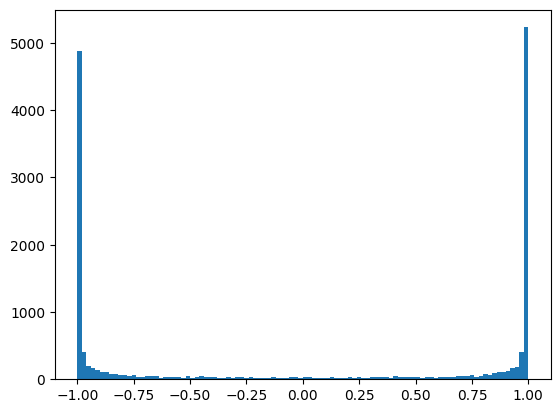

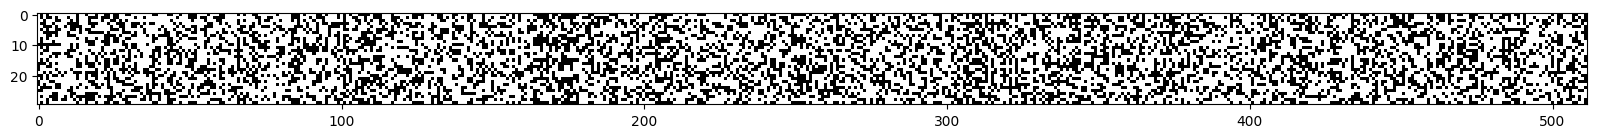

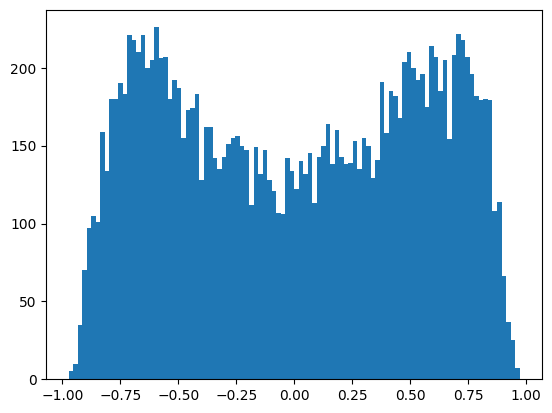

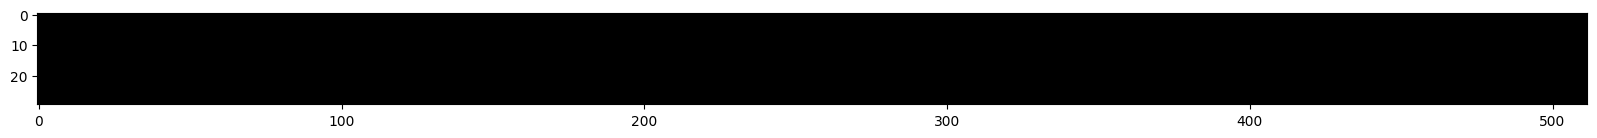

In [91]:
def visualize_activation(model: nn.Module, train_X: torch.Tensor, bins: int=100):
    # perform a forward pass
    probs, layer_data = model(train_X)

    # compute the results
    act_list = layer_data.view(-1).detach().numpy()
    plt.hist(act_list, bins=bins)
    plt.show()

    # also do advanced visualization
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.imshow(layer_data.abs() > 0.99, cmap="gray")
    plt.show()


visualize_activation(uni_model, train_X[:30])
# create he init
he_model = create_model()
init_weights(he_model, he_init)
visualize_activation(he_model, train_X[:30])

Try to optimize with additional information:

Epoch 0 - Train Loss: 2.8783979415893555 - Test Loss: 2.8796677589416504
Epoch 1 - Train Loss: 2.776932716369629 - Test Loss: 2.777600049972534
Epoch 2 - Train Loss: 2.723985433578491 - Test Loss: 2.724313259124756
Epoch 3 - Train Loss: 2.687688112258911 - Test Loss: 2.6879169940948486
Epoch 4 - Train Loss: 2.6600208282470703 - Test Loss: 2.660191535949707
Epoch 5 - Train Loss: 2.6377005577087402 - Test Loss: 2.637916326522827
Epoch 6 - Train Loss: 2.619028091430664 - Test Loss: 2.619281053543091
Epoch 7 - Train Loss: 2.6030025482177734 - Test Loss: 2.6031854152679443
Epoch 8 - Train Loss: 2.5888116359710693 - Test Loss: 2.58907151222229
Epoch 9 - Train Loss: 2.57619309425354 - Test Loss: 2.5765609741210938
Epoch 10 - Train Loss: 2.5647976398468018 - Test Loss: 2.5651907920837402
Epoch 11 - Train Loss: 2.5544326305389404 - Test Loss: 2.5548365116119385
Epoch 12 - Train Loss: 2.544902801513672 - Test Loss: 2.5453343391418457
Epoch 13 - Train Loss: 2.536073684692383 - Test Loss: 2.536549

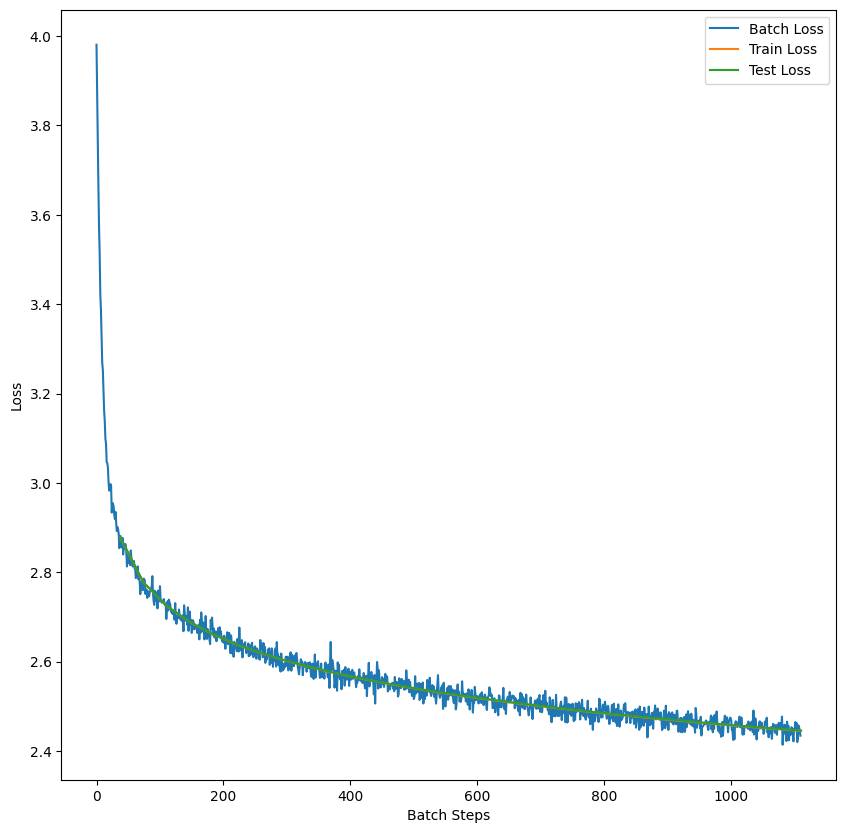

In [92]:
stats = optimize(
    he_model,
    30,
    train_X,
    train_y,
    dev_X,
    dev_y,
    ce_loss,
    batch_size=5000,
    lr=1e-2,
)
plot_stats(stats)

Now apply residual connections here as well

Epoch 0 - Train Loss: 2.8437509536743164 - Test Loss: 2.843942165374756
Epoch 1 - Train Loss: 2.7452454566955566 - Test Loss: 2.744641065597534
Epoch 2 - Train Loss: 2.6990890502929688 - Test Loss: 2.6981682777404785
Epoch 3 - Train Loss: 2.6669692993164062 - Test Loss: 2.6658437252044678
Epoch 4 - Train Loss: 2.642287254333496 - Test Loss: 2.641106605529785
Epoch 5 - Train Loss: 2.622187376022339 - Test Loss: 2.6208980083465576
Epoch 6 - Train Loss: 2.605224132537842 - Test Loss: 2.6040022373199463
Epoch 7 - Train Loss: 2.590588331222534 - Test Loss: 2.5894572734832764
Epoch 8 - Train Loss: 2.577644109725952 - Test Loss: 2.5765318870544434
Epoch 9 - Train Loss: 2.5660974979400635 - Test Loss: 2.5650689601898193
Epoch 10 - Train Loss: 2.555621385574341 - Test Loss: 2.5546669960021973
Epoch 11 - Train Loss: 2.5460424423217773 - Test Loss: 2.5450668334960938
Epoch 12 - Train Loss: 2.5372040271759033 - Test Loss: 2.5362892150878906
Epoch 13 - Train Loss: 2.5289580821990967 - Test Loss: 2.

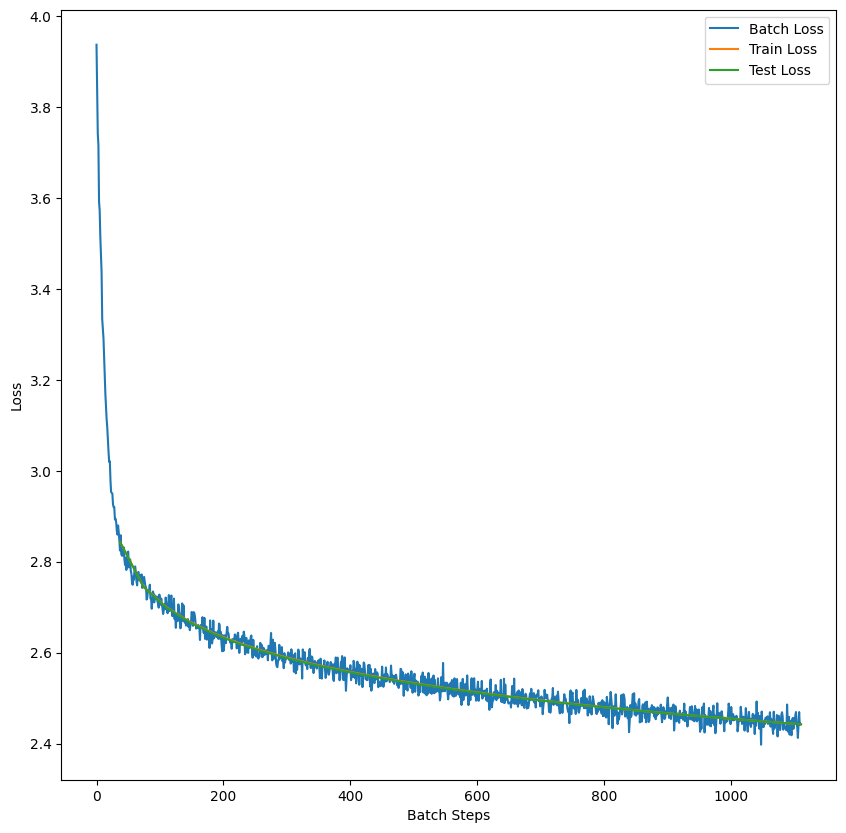

In [94]:
res_model = create_model(True)
init_weights(res_model, he_init)

stats = optimize(
    res_model,
    30,
    train_X,
    train_y,
    dev_X,
    dev_y,
    ce_loss,
    batch_size=5000,
    lr=1e-2,
)
plot_stats(stats)

Epoch 0 - Train Loss: 2.5473437309265137 - Test Loss: 2.5451624393463135
Epoch 1 - Train Loss: 2.367464065551758 - Test Loss: 2.3668477535247803
Epoch 2 - Train Loss: 2.2884256839752197 - Test Loss: 2.290212392807007
Epoch 3 - Train Loss: 2.269404888153076 - Test Loss: 2.2719027996063232
Epoch 4 - Train Loss: 2.281015396118164 - Test Loss: 2.2834436893463135
Epoch 5 - Train Loss: 2.238090991973877 - Test Loss: 2.2420170307159424
Epoch 6 - Train Loss: 2.240183115005493 - Test Loss: 2.244508743286133
Epoch 7 - Train Loss: 2.225315809249878 - Test Loss: 2.2294468879699707
Epoch 8 - Train Loss: 2.225470781326294 - Test Loss: 2.231889247894287
Epoch 9 - Train Loss: 2.2197558879852295 - Test Loss: 2.2258687019348145
Epoch 0 - Train Loss: 2.2120518684387207 - Test Loss: 2.2179503440856934
Epoch 1 - Train Loss: 2.2110531330108643 - Test Loss: 2.2174055576324463
Epoch 2 - Train Loss: 2.2102861404418945 - Test Loss: 2.2168734073638916
Epoch 3 - Train Loss: 2.2092208862304688 - Test Loss: 2.21573

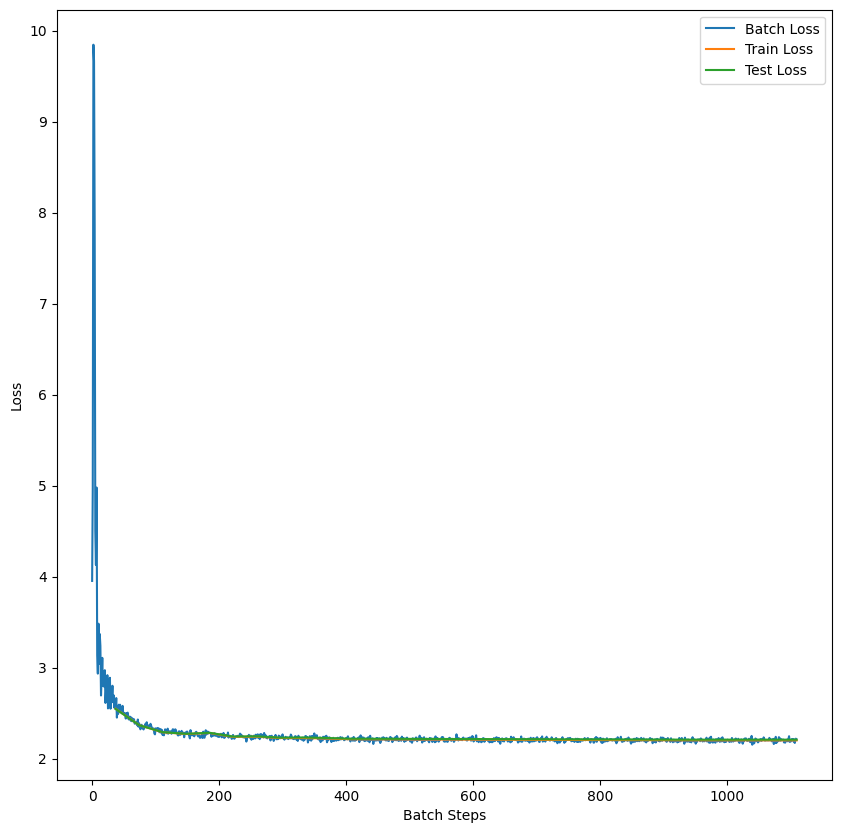

In [96]:
def train_regimen(model, epochs, lrs, batch_size=5000):
    stats = None
    for eps, lr in zip(epochs, lrs):
        stats = optimize(
            model,
            eps,
            train_X,
            train_y,
            dev_X,
            dev_y,
            ce_loss,
            batch_size=batch_size,
            lr=lr,
            stats=stats
        )
    plot_stats(stats)

reg_model = create_model(True)
init_weights(reg_model, he_init)
train_regimen(reg_model, [10, 15, 5], [5e-1, 1e-1, 1e-2])

**Batch Normalization**

Additionally we can apply batch normalization, whihc has similar effects than the inits, but is easier to use.

In [125]:
class MLPNet_BN(nn.Module):
    def __init__(
        self,
        char_map: Dict[int, str],
        num_items: int,
        emb_size: int = 64,
        hidden_size: int = 512,
        additional_hidden: int = 0,
        heads: int = 3,
        act: Callable[[torch.Tensor], torch.Tensor] = torch.tanh,
        residuals: bool = False,
        batchnorm: bool = True
    ):
        super(MLPNet_BN, self).__init__()
        self.heads = heads
        self.emb_size = emb_size
        self.act = act
        self.char_map = char_map
        self.use_res = residuals
        self.use_bn = batchnorm

        # generate data
        self.emb_mat = nn.Parameter(
            torch.randn(num_items, emb_size, requires_grad=True)
        )
        self.hidden = nn.Linear(heads * emb_size, hidden_size, bias=not batchnorm)
        self.add_hidden = [nn.Linear(hidden_size, hidden_size, bias=not batchnorm) for _ in range(additional_hidden)]
        for i, layer in enumerate(self.add_hidden):
            self.add_module(f"add_hidden_{i}", layer)

        # generate batchnorm data (this is just the distribution shift for each data point)
        if batchnorm:
            self.bn_gains = [nn.Parameter(torch.ones((1, hidden_size))) for _ in range(additional_hidden + 1)]
            # NOTE: in case of batchnorm this will be the main bias in the network
            self.bn_bias = [nn.Parameter(torch.zeros((1, hidden_size))) for _ in range(additional_hidden + 1)]
            # add parameters to the model
            for i in range(additional_hidden + 1):
                setattr(self, f"bn_gains_{i}", self.bn_gains[i])
                setattr(self, f"bn_bias_{i}", self.bn_bias[i])

        # generate out layer
        in_size = hidden_size + (emb_size * heads) if residuals else hidden_size
        self.out = nn.Linear(in_size, num_items)
        self.forward_data = {}

    def forward(self, x):
        # helper to store the forward data
        self.forward_data = {}

        # update the X (if out of shape)
        x = x.unqueeze(0) if len(x.shape) == 1 else x
        x = x.long()

        # retrieve embeddings and concat
        embs = self.emb_mat[x]
        embs = embs.view(-1, self.heads * self.emb_size)
        embs = self.act(embs)
        self.forward_data["embs"] = embs

        # hidden layers
        hidden = embs
        prev = None
        for i, layer in enumerate([self.hidden, *self.add_hidden]):
            hidden = layer(hidden)

            # apply batchnorm
            if self.use_bn:
                # take deviation from the regular mean (and allow to shift with gain) and divide by std (to normalize it)
                # also allow to use a bias to shift away
                hidden = self.bn_gains[i] * (hidden - hidden.mean()) / (hidden.std() + 1e-8) + self.bn_bias[i]
            
            hidden = self.act(hidden)

            self.forward_data[f"hidden{i}"] = hidden

            if self.use_res and prev is not None:
                hidden = hidden + prev
                self.forward_data[f"hidden{i}_res"] = hidden
            prev = hidden



        # add residual
        if self.use_res:
            hidden = torch.cat((hidden, embs), dim=1)
        logits = self.out(hidden)
        self.forward_data["logits"] = logits
        return logits, hidden

    def predict_proba(self, x):
        return torch.softmax(self.forward(x)[0], dim=1)

    def predict(self, x):
        logits = self.predict_proba(x)
        return torch.argmax(logits, dim=1)

    def sample_word(self, size: int = 100) -> str:
        word = ""
        chars = [0] * self.heads
        for i in range(size):
            probs = self.predict_proba(torch.tensor([chars]))
            # sample from the distribution
            sample = torch.multinomial(probs[0], 1, replacement=True).item()
            if sample == 0:
                break

            chars = chars[1:] + [sample]
            word += self.char_map[sample]

        return word

    def plot_embeddings(self):
        emb_points = self.emb_mat.detach().numpy()

        # use PCA to reduce the dimensionality
        if emb_points.shape[1] > 2:
            pca = PCA(n_components=2)
            emb_points = pca.fit_transform(emb_points)

        # plot the embedding points on a 2D plane
        plt.figure(figsize=(10, 10))
        # and label the points
        plt.scatter(emb_points[:, 0], emb_points[:, 1], s=250)

        # plot the labels
        for i, label in enumerate(pos_map):
            plt.annotate(
                label,
                (emb_points[i, 0], emb_points[i, 1]),
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )
        plt.show()

def create_model_bn(res = False, bn=True, add_layer=5):
    return MLPNet_BN(
        items,
        num_items,
        emb_size=emb_size,
        hidden_size=hidden_layer,
        additional_hidden=add_layer,
        heads=heads,
        act=torch.nn.Tanh(),
        residuals=res,
        batchnorm=bn
    )

bn_model = create_model_bn()
init_weights(bn_model, he_init)
print(f"Number of parameters: {count_parameters(bn_model)}")

Number of parameters: 1496283


In [137]:
train_regimen(bn_model, [10, 15, 5], [5e-1, 1e-1, 1e-2])

Epoch 0 - Train Loss: 2.8223185539245605 - Test Loss: 2.8220269680023193


KeyboardInterrupt: 

In [138]:
no_bn_model = create_model_bn(bn=False)
init_weights(no_bn_model, he_init)
train_regimen(no_bn_model, [10, 15, 5], [5e-1, 1e-1, 1e-2])

Epoch 0 - Train Loss: 127.05841827392578 - Test Loss: 127.05733489990234


KeyboardInterrupt: 

Epoch 0 - Train Loss: 2.5054759979248047 - Test Loss: 2.505943775177002
Epoch 1 - Train Loss: 2.3377158641815186 - Test Loss: 2.3371026515960693
Epoch 2 - Train Loss: 2.2985711097717285 - Test Loss: 2.2990739345550537
Epoch 3 - Train Loss: 2.2788102626800537 - Test Loss: 2.2784271240234375
Epoch 4 - Train Loss: 2.2825722694396973 - Test Loss: 2.2851004600524902
Epoch 5 - Train Loss: 2.2422165870666504 - Test Loss: 2.244936466217041
Epoch 6 - Train Loss: 2.255310297012329 - Test Loss: 2.25651216506958
Epoch 7 - Train Loss: 2.2389724254608154 - Test Loss: 2.2414450645446777
Epoch 8 - Train Loss: 2.2295384407043457 - Test Loss: 2.234144687652588
Epoch 9 - Train Loss: 2.2298500537872314 - Test Loss: 2.2346346378326416
Epoch 0 - Train Loss: 2.2157206535339355 - Test Loss: 2.2206575870513916
Epoch 1 - Train Loss: 2.2141530513763428 - Test Loss: 2.2192628383636475
Epoch 2 - Train Loss: 2.2132177352905273 - Test Loss: 2.218477964401245
Epoch 3 - Train Loss: 2.211632251739502 - Test Loss: 2.217

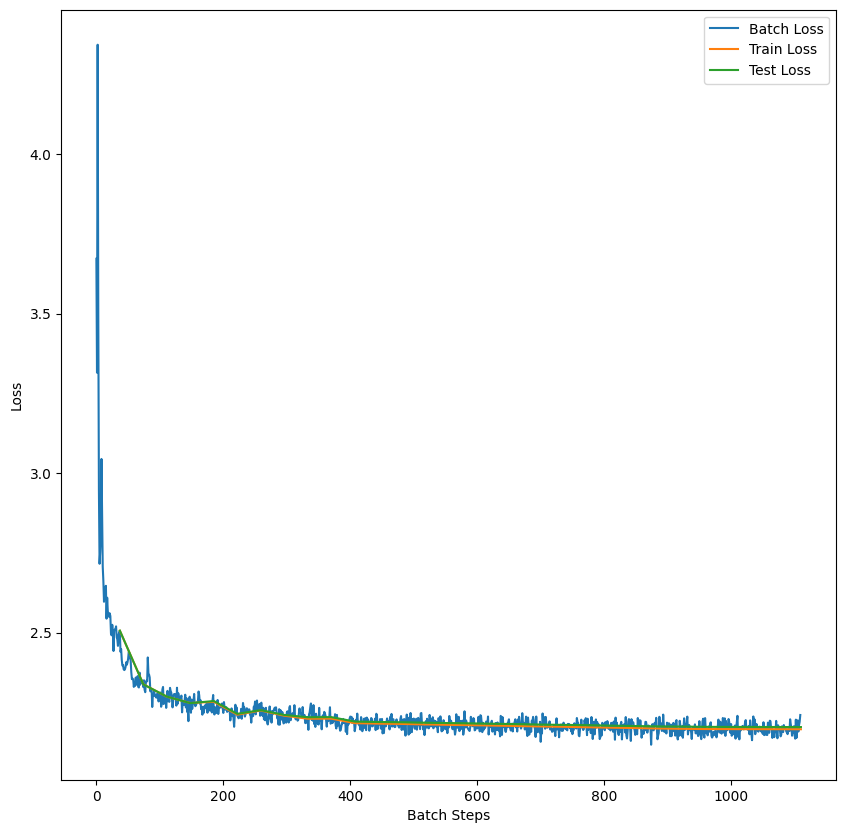

In [121]:
bn_res_model = create_model_bn(bn=True, res=True)
init_weights(bn_res_model, he_init)
train_regimen(bn_res_model, [10, 15, 5], [5e-1, 1e-1, 1e-2])

**More Normalization**

Group & Layer Normalizaton can be easier to use than batch normalization (since they do not couple input examples).

> Common error is to forget setting training flag to false (meaning statistics from test data leak into the model!!)

**Visalize Activation Distributions**

This can be helpful to detect exploding or vanishing gradients. (Basically indicates if the system not regularized enough or there is major distribution shift happening between layers)

/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_38791/1055733197.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 1, 1)


torch.Size([27, 64]) grad to data 0.0051888697780668736
torch.Size([512, 320]) grad to data 0.002544573275372386
torch.Size([512, 512]) grad to data 0.003981269430369139
torch.Size([512, 512]) grad to data 0.006050011608749628
torch.Size([512, 512]) grad to data 0.01406352873891592
torch.Size([512, 512]) grad to data 0.039135195314884186
torch.Size([512, 512]) grad to data 0.13532790541648865
torch.Size([27, 512]) grad to data 1.5546371936798096


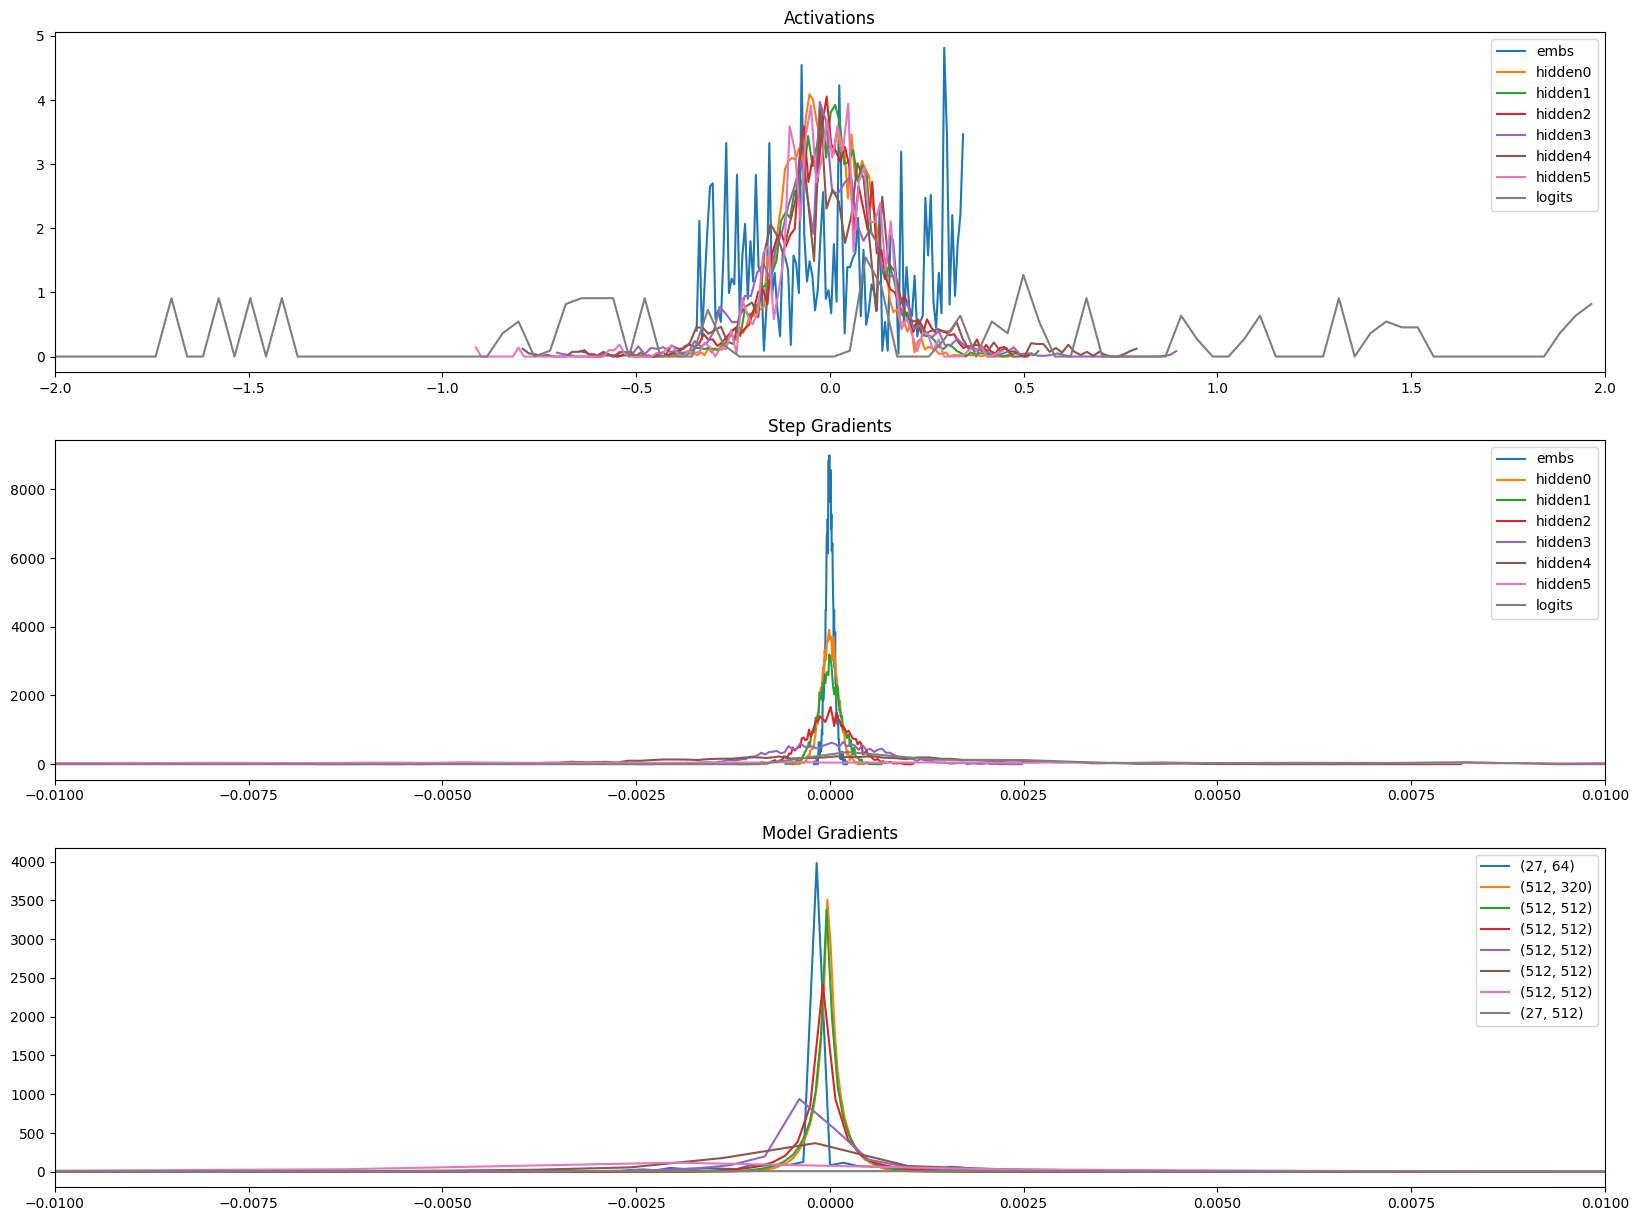

In [156]:
def visualize_forward(model, X, y):
    logits = model.forward(X)[0]
    data = model.forward_data

    # create two stacked plots
    fig = plt.subplots(figsize=(20, 20))
    ax = plt.subplot(4, 1, 1)

    # plot the logits
    ax.set_title("Activations")
    for name in data:
        tdata = torch.histogram(data[name], density=True)
        ax.plot(tdata[1][:-1].detach(), tdata[0].detach(), label=name)
        data[name].retain_grad()
    # set limits on x axis
    ax.set_xbound(-2, 2)
    ax.legend()

    # go back
    loss = ce_loss(logits, y)
    loss.backward()

    # get gradient data
    ax = plt.subplot(4, 1, 2)
    ax.set_title("Step Gradients")
    for name in data:
        tdata = torch.histogram(data[name].grad, density=True)
        ax.plot(tdata[1][:-1].detach(), tdata[0].detach(), label=name)
    ax.set_xbound(-.01, .01)
    ax.legend()

    # iterate model parameters
    ax = plt.subplot(4, 1, 3)
    ax.set_title("Model Gradients")
    for p in model.parameters():
        t = p.grad
        if t is None or t.ndim < 2 or t.shape[0] == 1:
            continue
        print(f"{t.shape} grad to data {t.std() / p.std()}")
        tdata = torch.histogram(t, density=True)
        ax.plot(tdata[1][:-1].detach(), tdata[0].detach(), label=f"{tuple(t.shape)}")
    ax.set_xbound(-.01, .01)
    ax.legend()

    # iterate model parameters
    ax = plt.subplot(4, 1, 4)
    ax.set_title("LR dep Weight Updates")
    # TODO: get data here (needs to be computed in forward pass)
    ax.legend()
    
    plt.show()

visualize_forward(bn_model, train_X[:10], train_y[:10])

/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_38791/1055733197.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 1, 1)


torch.Size([27, 64]) grad to data 0.0001303688040934503
torch.Size([512, 320]) grad to data 6.906147609697655e-05
torch.Size([512, 512]) grad to data 0.00027781823882833123
torch.Size([512, 512]) grad to data 0.0008576266118325293
torch.Size([512, 512]) grad to data 0.003613638924434781
torch.Size([512, 512]) grad to data 0.020073387771844864
torch.Size([512, 512]) grad to data 0.9249948263168335
torch.Size([27, 512]) grad to data 3.2714555263519287


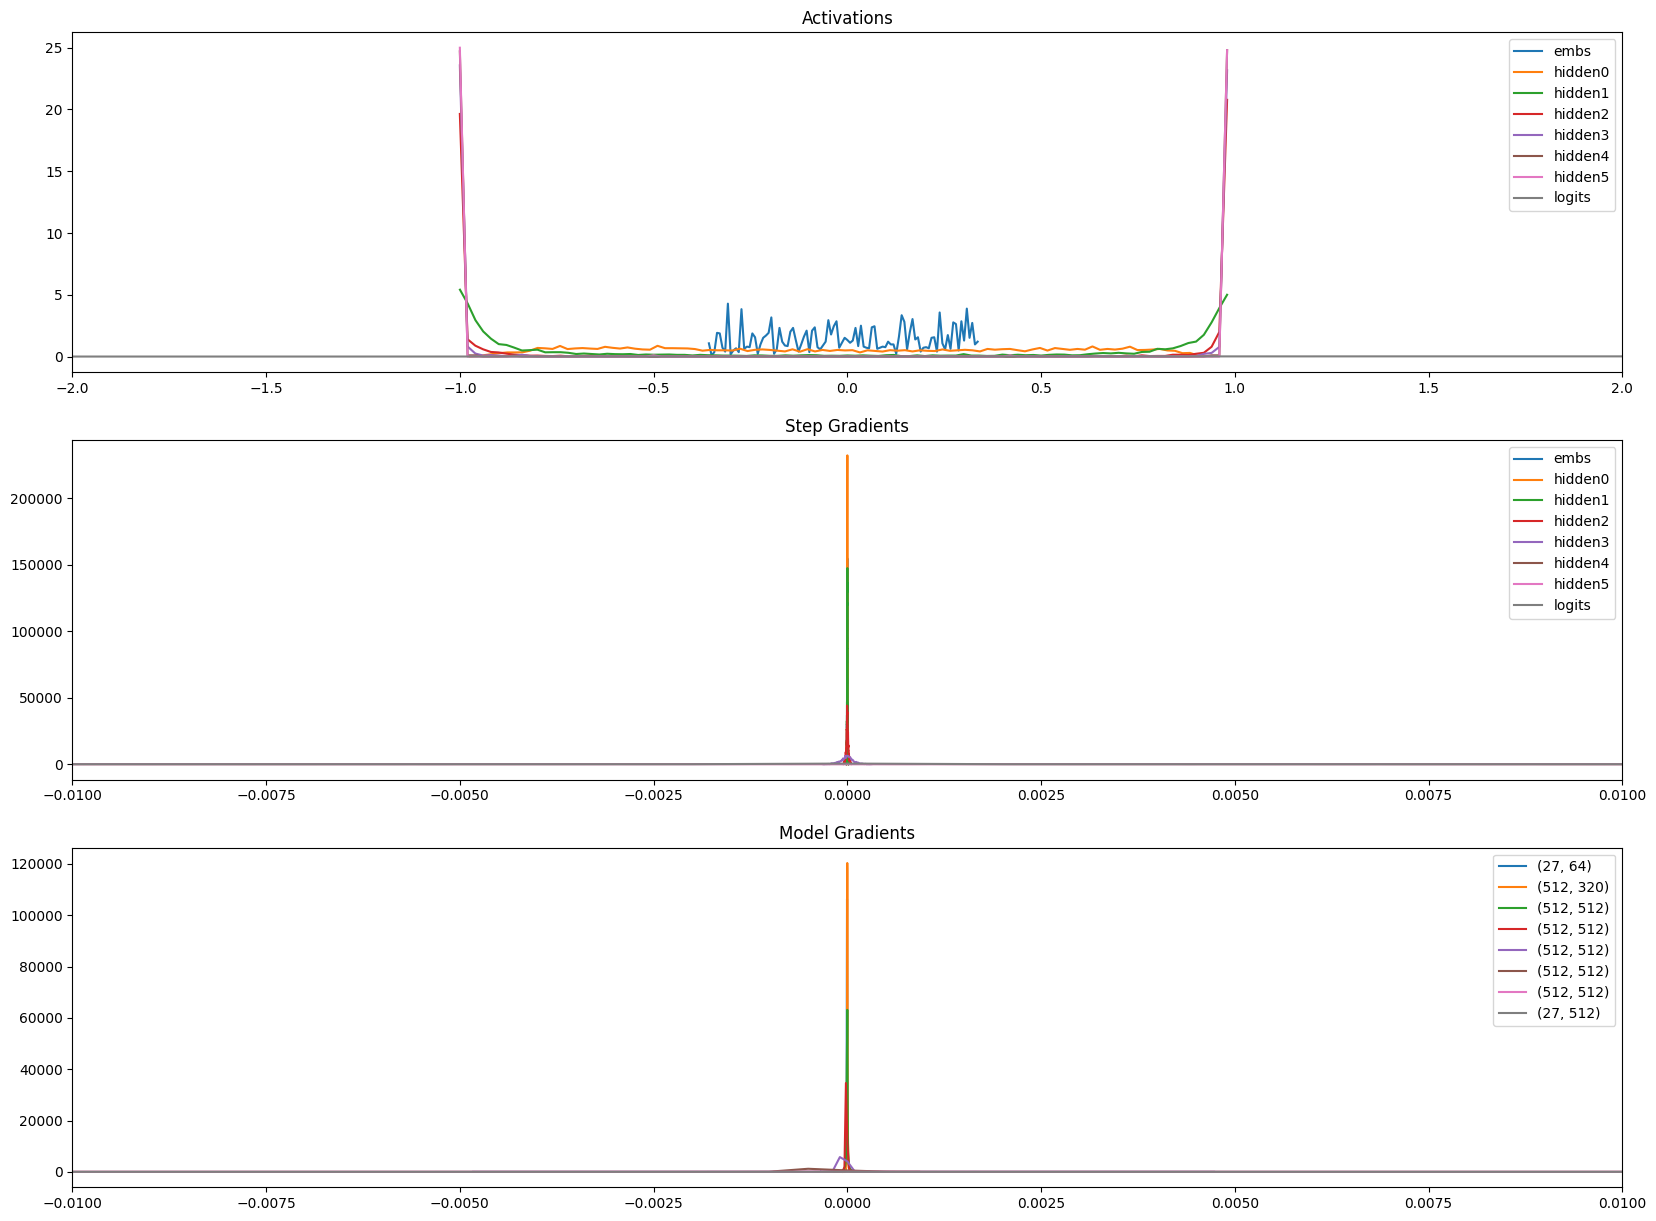

In [157]:
visualize_forward(no_bn_model, train_X[:10], train_y[:10])

We can clearly see the vanishing gradient problem for deep tanh networks in the non batch normalized case.

**Additional Data**

There can be additional data added in form of:

- saturation of layer
    - For TanH number of activations that are in the tail of the distribution -> This will change depending on the activation function
- gradient to data ratio
    - Basically the std of the gradient divided by the std of the data (to understand the percentage of the update)
- Update Ratio (should not be below -3) 
    - to low might mean too small learning rate
    - much above -3 would mean too high / imbalanced learning rate

In [158]:
model.emb_mat.data.device

device(type='cpu')